In [ ]:
#| include: false

import os
import h5py
import pandas as pd
import numpy as np
import toml
from pathlib import Path
import geopandas as gpd
import summary_data

config = summary_data.CONFIG
all_runs = summary_data.ALL_RUNS

In [ ]:
# network summary: 'VMT','VHT','total_delay'
network = summary_data.load_agg_data('network/network_results.csv')
# delay
delay = summary_data.load_agg_data('network/delay_user_class.csv')

In [ ]:
# truck_h5['am']['mf'+'am'+'_medtrk_trips'][:].sum()

66613.31

In [ ]:
# network 
df_network = network.copy()
df_network['medium_truck_vmt'] = df_network['@mveh']*df_network['length']
df_network['heavy_truck_vmt'] = df_network['@hveh']*df_network['length']
df_network['truck_vmt'] = df_network['heavy_truck_vmt']+df_network['medium_truck_vmt']

# Results by Congestion Level
df_network['speed'] = df_network['length']/df_network['auto_time']*60
df_network['congestion_index'] = df_network['speed']/df_network['data2']
df_network['congestion_index'] = df_network['congestion_index'].clip(0,1)
df_network['congestion_category'] = pd.cut(df_network['congestion_index'], bins=[0,.25,.5,.7,1], labels=['Severe','Heavy','Moderate','Light'])

# add order for county
df_network["county"] = pd.Categorical(df_network["county"], categories = ['King', 'Snohomish', 'Pierce', 'Kitsap', 'Outside Region'], ordered=True)

In [33]:
pd.options.display.float_format = '{:0,.0f}'.format

## truck miles traveled

In [15]:
tab = df_network.groupby(['source'])[['truck_vmt','medium_truck_vmt','heavy_truck_vmt']].sum().\
        rename(columns={'truck_vmt': 'all trucks',
                        'medium_truck_vmt': 'medium trucks',
                        'heavy_truck_vmt': 'heavy trucks'})
tab['Total'] = tab.sum(axis=1)

display(tab.style.format('{:,.0f}'))

,all trucks,medium trucks,heavy trucks,Total
source,,,,
2023 base year,"6,310,148","3,456,601","2,853,547","12,620,297"
2050,"7,636,366","3,811,855","3,824,511","15,272,731"
2050 (no telecommute),"7,691,204","3,866,151","3,825,053","15,382,408"


In [26]:
tab = df_network.groupby(['source','county'])['truck_vmt'].sum().\
        reset_index().\
        pivot(index='source', columns='county')['truck_vmt'].\
        rename_axis(columns={'county': 'Truck VMT by county'})
tab['Total'] = tab.sum(axis=1)

display(tab.style.format('{:,.0f}'))

Truck VMT by county,King,Snohomish,Pierce,Kitsap,Outside Region,Total
source,,,,,,
2023 base year,"3,632,964","1,192,997","1,200,370","258,097","25,721","6,310,148"
2050,"4,352,853","1,499,573","1,456,986","281,949","45,005","7,636,366"
2050 (no telecommute),"4,370,892","1,502,572","1,470,978","301,376","45,386","7,691,204"


In [27]:
tab = df_network.groupby(['source','county'])['medium_truck_vmt'].sum().\
        reset_index().\
        pivot(index='source', columns='county')['medium_truck_vmt'].\
        rename_axis(columns={'county': 'Medium truck VMT by county'})
tab['Total'] = tab.sum(axis=1)

display(tab.style.format('{:,.0f}'))

Medium truck VMT by county,King,Snohomish,Pierce,Kitsap,Outside Region,Total
source,,,,,,
2023 base year,"2,093,196","607,655","595,233","160,360",156,"3,456,601"
2050,"2,281,982","714,253","635,226","171,831","8,562","3,811,855"
2050 (no telecommute),"2,299,121","717,430","649,397","191,235","8,968","3,866,151"


In [28]:
tab = df_network.groupby(['source','county'])['heavy_truck_vmt'].sum().\
        reset_index().\
        pivot(index='source', columns='county')['heavy_truck_vmt'].\
        rename_axis(columns={'county': 'Heavy truck VMT by county'})
tab['Total'] = tab.sum(axis=1)

display(tab.style.format('{:,.0f}'))

Heavy truck VMT by county,King,Snohomish,Pierce,Kitsap,Outside Region,Total
source,,,,,,
2023 base year,"1,539,768","585,342","605,137","97,737","25,564","2,853,547"
2050,"2,070,871","785,320","821,760","110,118","36,443","3,824,511"
2050 (no telecommute),"2,071,771","785,142","821,580","110,141","36,418","3,825,053"


## vehicle delay

In [31]:
tab = delay.groupby('source')[['@hveh','@mveh']].sum().\
        rename(columns={'@mveh': 'medium trucks',
                        '@hveh': 'heavy trucks'})
tab

,heavy trucks,medium trucks
source,,
2023 base year,9678.749109,11702.780105
2050,19222.851066,14396.807443
2050 (no telecommute),19960.984615,15818.925683


## vehicle trips

In [ ]:
# truck_h5 = h5py.File(Path(list(all_runs.values())[0])/'outputs/trucks/truck_trips.h5', 'r')

def load_h5_data(file_path: str, tod_list: list(), 2nd_layer: str):

    df = pd.DataFrame()
    for comparison_run in ALL_RUNS.keys():
        
        full_file_path = get_output_path(comparison_run) / file_path

        df_run = h5py.File(full_file_path, 'r')

        df_run["source"] = comparison_run
        df = pd.concat([df, df_run])

    return df

In [71]:

truck_h5['am']['mfam_hvytrk_trips']['0:3751, 0:3751']

ValueError: Field names only allowed for compound types

In [62]:
# for 
total_med_trips = 0
total_hvy_trips = 0
for tod in ['am','md','pm','ev','ni']:
    total_med_trips += truck_h5[tod]['mf'+tod+'_medtrk_trips'][:].sum()
    total_hvy_trips += truck_h5[tod]['mf'+tod+'_hvytrk_trips'][:].sum()

_df_trips = pd.DataFrame({'Trips': [total_hvy_trips, total_med_trips]}, index=['Heavy Trucks', 'Medium Trucks'])

In [63]:
_df_trips

,Trips
Heavy Trucks,134623.184570
Medium Trucks,320256.330078


In [42]:
skim_h5 = h5py.File('../../../../inputs/model/roster/7to8.h5', 'r')
skim_h5

<HDF5 file "7to8.h5" (mode r)>

In [43]:
skim_h5 = h5py.File('../../../../inputs/model/roster/7to8.h5', 'r')

wt = (truck_h5['am']['mfam_hvytrk_trips'][0:3751, 0:3751] * (skim_h5['Skims']['heavy_truckd'][:]/100.0)[0:3751, 0:3751]).sum()
hvy_dist = wt/truck_h5['am']['mfam_hvytrk_trips'][0:3751, 0:3751].sum()

wt = (truck_h5['am']['mfam_medtrk_trips'][0:3751, 0:3751] * (skim_h5['Skims']['medium_truckd'][:]/100.0)[0:3751, 0:3751]).sum()
med_dist = wt/truck_h5['am']['mfam_medtrk_trips'][0:3751, 0:3751].sum()


_df_dist = pd.DataFrame({'Average Distance (mi)': [hvy_dist, med_dist]}, index=['Heavy Trucks', 'Medium Trucks'])

In [44]:
df_combined = pd.concat([_df_vmt, _df_delay, _df_trips, _df_dist], axis=1)
df_combined['Average Distance (mi)'] = df_combined['Average Distance (mi)'].map('{:.1f}'.format)
df_combined

,VMT,Hours of Delay,Trips,Average Distance (mi)
Heavy Trucks,"2,853,578","9,585","134,623",38.7
Medium Trucks,"3,454,952","11,582","320,256",15.0


In [45]:
_df_trips

,Trips
Heavy Trucks,"134,623"
Medium Trucks,"320,256"


In [77]:
truck_h5 = h5py.File('../../../../outputs/trucks/truck_trips.h5', 'r')

# External-external trips
ext_med_trips = 0
ext_hvy_trips = 0
for tod in ['am','md','pm','ev','ni']:
    ext_med_trips += truck_h5[tod]['mf'+tod+'_medtrk_trips'][3700:,3700:].sum()
    ext_hvy_trips += truck_h5[tod]['mf'+tod+'_hvytrk_trips'][3700:,3700:].sum()

thru_truck_trips = pd.DataFrame({'Trips': [ext_hvy_trips, ext_med_trips]}, index=['Heavy Trucks', 'Medium Trucks'])
thru_truck_trips

,Trips
Heavy Trucks,"4,530"
Medium Trucks,0


In [ ]:
# Internal ->  external trips
ext_med_trips = 0
ext_hvy_trips = 0
for tod in ['am','md','pm','ev','ni']:
    ext_med_trips += truck_h5[tod]['mf'+tod+'_medtrk_trips'][:3701,3700:].sum()
    ext_hvy_trips += truck_h5[tod]['mf'+tod+'_hvytrk_trips'][:3701,3700:].sum()

_df_trips = pd.DataFrame({'Trips': [ext_hvy_trips, ext_med_trips]}, index=['Heavy Trucks', 'Medium Trucks'])
_df_trips

,Trips
Heavy Trucks,"22,236"
Medium Trucks,0


In [73]:
# External ->  internal trips
ext_med_trips = 0
ext_hvy_trips = 0
for tod in ['am','md','pm','ev','ni']:
    ext_med_trips += truck_h5[tod]['mf'+tod+'_medtrk_trips'][3700:,:3701].sum()
    ext_hvy_trips += truck_h5[tod]['mf'+tod+'_hvytrk_trips'][3700:,:3701].sum()

_df_trips = pd.DataFrame({'Trips': [ext_hvy_trips, ext_med_trips]}, index=['Heavy Trucks', 'Medium Trucks'])
_df_trips

,Trips
Heavy Trucks,"22,236"
Medium Trucks,0


In [79]:
# Total Trips
(_df_trips*2) - thru_truck_trips

,Trips
Heavy Trucks,"39,941"
Medium Trucks,0


In [70]:
# All external trips
ext_med_trips = 0
ext_hvy_trips = 0
for tod in ['am','md','pm','ev','ni']:
    ext_med_trips += truck_h5[tod]['mf'+tod+'_medtrk_trips'][3700:,3700:].sum()
    ext_hvy_trips += truck_h5[tod]['mf'+tod+'_hvytrk_trips'][3700:,3700:].sum()

_df_trips = pd.DataFrame({'Trips': [ext_hvy_trips, ext_med_trips]}, index=['Heavy Trucks', 'Medium Trucks'])
_df_trips

,Trips
Heavy Trucks,"4,530"
Medium Trucks,0


In [51]:
truck_h5['am']['mfam_medtrk_trips'][3700:,3700:].sum()

0.0

In [52]:
# Speed between ODs / Travel time between ODs

In [53]:
# % of VMT within MICs

## VMT By Congestion Level

In [65]:
# Results by Congestion Level
df['speed'] = df['length']/df['auto_time']*60
df['congestion_index'] = df['speed']/df['data2']
df['congestion_index'] = df['congestion_index'].clip(0,1)
df['congestion_category'] = pd.cut(df['congestion_index'], bins=[0,.25,.5,.7,0.99,1], labels=['Severe','Heavy','Moderate','Light','None'])

### Miles of Roadway with AM Congestion

In [67]:
time_period_list = ['7to8']
_df = df[df['tod'].isin(time_period_list)]
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='length')
_df = _df/len(time_period_list)
_df.to_clipboard()
_df

county,King,Kitsap,Outside Region,Pierce,Snohomish
congestion_category,,,,,
Severe,33,1,0,5,6
Heavy,252,9,0,82,55
Moderate,432,21,0,194,128
Light,"1,608",377,1,"1,037",778
None,"4,371","1,030",39,"2,541","2,206"


In [68]:
time_period_list = ['7to8']
_df = df[df['tod'].isin(time_period_list) & (df['@fgts'].isin([1,2]))]
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='length')
_df = _df/len(time_period_list)
_df.to_clipboard()
_df

county,King,Kitsap,Outside Region,Pierce,Snohomish
congestion_category,,,,,
Severe,9,0,0,2,0
Heavy,120,2,0,37,19
Moderate,142,1,0,72,48
Light,426,73,0,271,191
None,325,31,0,140,107


AM Peak (5 - 9 am)

In [16]:
df['Medium and Heavy Trucks'] = df['heavy_truck_vmt']+df['medium_truck_vmt']

_df = df[df['tod'].isin(['5to6','6to7','7to8','8to9'])]
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='Medium and Heavy Trucks')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df.loc['Total',:] = _df.sum()
_df

,King,Kitsap,Outside Region,Pierce,Snohomish
Light,"552,066","52,288","5,481","200,099","216,098"
Moderate,"132,933",922,0,"41,906","28,194"
Heavy,"83,849",617,0,"12,676","9,017"
Severe,"4,955",29,0,334,714
Total,"773,803","53,856","5,481","255,015","254,023"


PM Peak (3 - 6 pm)

In [17]:
_df = df[df['tod'].isin(['15to16','16to17','17to18'])]
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='Medium and Heavy Trucks')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df.loc['Total',:] = _df.sum()
_df

,King,Kitsap,Outside Region,Pierce,Snohomish
Light,"452,633","44,805","4,518","163,101","176,357"
Moderate,"129,362",736,7,"38,428","32,481"
Heavy,"79,806",588,0,"15,908","8,377"
Severe,"5,910",51,0,406,630
Total,"667,712","46,180","4,525","217,843","217,845"


# Share of Truck Miles by Truck Type
Daily Total

In [18]:
_df = df[['medium_truck_vmt','heavy_truck_vmt','county']].melt(
    id_vars='county', var_name='Truck Type')
_df = _df.pivot_table(index='Truck Type', columns='county', 
                values='value', aggfunc='sum')
_df.rename(index={'heavy_truck_vmt': 'Heavy Trucks',
                 'medium_truck_vmt': 'Medium Trucks'}, inplace=True)
_df.index.name = None
_df.columns.name = None
_df.sort_index(ascending=False, inplace=True)
_df_val = _df.copy()
_df.loc['Total',:] = _df.sum()
_df

,King,Kitsap,Outside Region,Pierce,Snohomish
Medium Trucks,"2,093,196","160,360",156,"595,233","607,655"
Heavy Trucks,"1,539,768","97,737","25,564","605,137","585,342"
Total,"3,632,964","258,097","25,721","1,200,370","1,192,997"


In [19]:
pd.options.display.float_format = '{:0,.1%}'.format
_df_val/_df_val.sum()

,King,Kitsap,Outside Region,Pierce,Snohomish
Medium Trucks,57.6%,62.1%,0.6%,49.6%,50.9%
Heavy Trucks,42.4%,37.9%,99.4%,50.4%,49.1%


# Truck Miles on FGTS
Freight and Goods Transportation System
- T-1: More than 10 million tons per year
- T-2: 2 4 million to 10 million tons per year

In [20]:
df['Medium and Heavy Trucks'] = df['heavy_truck_vmt']+df['medium_truck_vmt']
df['Passenger VMT'] = df['VMT']-df['Medium and Heavy Trucks']
# df['@tveh'].sum()
df['VMT'].sum()

83284422.86125325

In [21]:
pd.options.display.float_format = '{:0,.0f}'.format
_df = df[['medium_truck_vmt','heavy_truck_vmt','@fgts','Passenger VMT']].melt(
    id_vars='@fgts', var_name='Vehicle Type')
_df = _df.pivot_table(index='Vehicle Type', columns='@fgts', 
                values='value', aggfunc='sum')
# _df = _df.reset_index()
_df = _df.rename_axis(None, axis=1)
_df.rename(columns={0:'Other Routes', 1: 'T-1', 2: 'T-2'}, inplace=True)
_df.rename(index={'heavy_truck_vmt': 'Heavy Truck VMT',
                 'medium_truck_vmt': 'Medium Truck VMT'}, inplace=True)
_df[['T-1','T-2','Other Routes']]

,T-1,T-2,Other Routes
Vehicle Type,,,
Passenger VMT,"30,322,301","11,563,923","35,088,051"
Heavy Truck VMT,"2,284,776","190,393","378,378"
Medium Truck VMT,"1,898,242","536,835","1,021,524"


In [22]:
pd.options.display.float_format = '{:0,.1%}'.format
_df[['T-1','T-2','Other Routes']]/_df[['T-1','T-2','Other Routes']].sum()

,T-1,T-2,Other Routes
Vehicle Type,,,
Passenger VMT,87.9%,94.1%,96.2%
Heavy Truck VMT,6.6%,1.5%,1.0%
Medium Truck VMT,5.5%,4.4%,2.8%


In [23]:
# Combine T-1 and T-2
pd.options.display.float_format = '{:0,.0f}'.format

df['Passenger VMT'] = df['VMT']-df['Medium and Heavy Trucks']
df['route_type']  = 'Other Streets'
df.loc[df['@fgts'].isin([1,2]),'route_type'] = 'Major Truck Routes'
_df = df.copy()
_df.rename(columns={'heavy_truck_vmt': 'Heavy Truck VMT',
                 'medium_truck_vmt': 'Medium Truck VMT'}, inplace=True)
_df = _df.groupby('route_type')[['Medium Truck VMT','Heavy Truck VMT','Passenger VMT']].sum().T
_df.loc[['Passenger VMT','Heavy Truck VMT','Medium Truck VMT'],:]

route_type,Major Truck Routes,Other Streets
Passenger VMT,"41,886,223","35,088,051"
Heavy Truck VMT,"2,475,169","378,378"
Medium Truck VMT,"2,435,077","1,021,524"


# Truck Congestion on FGTS
AM Peak (5 - 9 am)

In [24]:
# Congested Miles on FGTS versus other Routes
df['Medium and Heavy Trucks'] = df['@mveh']+df['@hveh']

_df = df[df['tod'].isin(['5to6','6to7','7to8','8to9'])]
_df = _df.pivot_table(index='congestion_category',columns='@fgts',
               aggfunc='sum',values='Medium and Heavy Trucks')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df.rename(columns={0:'Other Routes', 1: 'T-1', 2: 'T-2'}, inplace=True)
_df_ = _df.copy()
_df.loc['Total',:] = _df.sum()
_df = _df[['T-1','T-2','Other Routes']]
_df

,T-1,T-2,Other Routes
Light,"1,936,183","793,680","1,613,555"
Moderate,"473,609","93,550","186,846"
Heavy,"262,314","74,174","154,050"
Severe,"21,287","26,767","65,028"
Total,"2,693,393","988,171","2,019,479"


In [25]:
pd.options.display.float_format = '{:0,.1%}'.format
_df_/_df_.sum()

,Other Routes,T-1,T-2
Light,79.9%,71.9%,80.3%
Moderate,9.3%,17.6%,9.5%
Heavy,7.6%,9.7%,7.5%
Severe,3.2%,0.8%,2.7%


PM Peak (3 - 6 pm)

In [26]:
pd.options.display.float_format = '{:0,.0f}'.format
# Congested Miles on FGTS versus other Routes
df['Medium and Heavy Trucks'] = df['@hveh']+df['@mveh']

_df = df[df['tod'].isin(['15to16','16to17','17to18'])]
_df = _df.pivot_table(index='congestion_category',columns='@fgts',
               aggfunc='sum',values='Medium and Heavy Trucks')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df.rename(columns={0:'Other Routes', 1: 'T-1', 2: 'T-2'}, inplace=True)
_df_ = _df.copy()
_df.loc['Total',:] = _df.sum()
_df = _df[['T-1','T-2','Other Routes']]
_df

,T-1,T-2,Other Routes
Light,"1,528,804","668,479","1,366,812"
Moderate,"469,364","90,309","183,103"
Heavy,"244,137","72,699","158,224"
Severe,"30,305","28,350","62,567"
Total,"2,272,610","859,837","1,770,707"


In [27]:
pd.options.display.float_format = '{:0,.1%}'.format
_df_/_df_.sum()

,Other Routes,T-1,T-2
Light,77.2%,67.3%,77.7%
Moderate,10.3%,20.7%,10.5%
Heavy,8.9%,10.7%,8.5%
Severe,3.5%,1.3%,3.3%


# Households Within 500' of Heavy Truck Volumes
Total number of households within 500' of T-1 and T-2 routes
- T-1: More than 10 million tons per year
- T-2: 2 4 million to 10 million tons per year

In [46]:
# Intersect buffer with land use file
df_lu = pd.read_csv(r'..\..\..\..\outputs\landuse\parcels_urbansim.txt',
                   sep='\s+')

# Load as a geodataframe
gdf_lu = gpd.GeoDataFrame(
    df_lu, geometry=gpd.points_from_xy(df_lu.xcoord_p, df_lu.ycoord_p))

crs = {'init' : 'EPSG:2285'}
gdf_lu.crs = crs

# Buffer the parcels at 500ft
gdf_lu['geometry'] = gdf_lu.buffer(500)

c:\Users\Modeller\AppData\Local\anaconda3\envs\summary\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [48]:

# Intersect this geography  with the network shapefile
gdf_network = gpd.read_file(r'..\..\..\..\inputs\scenario\networks\shapefiles\AM\AM_edges.shp')
# Do not include connectors since these are abstracted ul3==5; also remove weave links ul3==0 
gdf_network = gdf_network[~gdf_network.ul3.isin([0,5])]
# Truck network links are those that are in FGTS 1 or 2 system
gdf_network = gdf_network[gdf_network['FGTS'].isin([1,2])]

gdf_intersect = gpd.overlay(gdf_network, gdf_lu, how="intersection", keep_geom_type=False)

# Will need to relaculate the lengths since some were split across the regional geographies
gdf_intersect['new_length'] = gdf_intersect.geometry.length/5280.0

# filter out the polygon results and only keep lines
gdf_intersect = gdf_intersect[gdf_intersect.geometry.type.isin(['MultiLineString','LineString'])]

<AxesSubplot:>

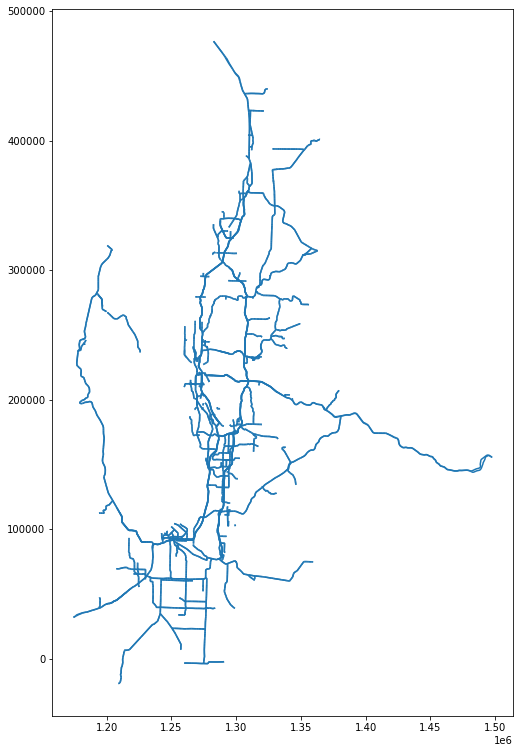

In [49]:
gdf_network.plot(figsize=(13,13))

In [50]:
truck_parcels = gdf_intersect.groupby('parcelid').first()[['hh_p']].reset_index()


# Result should be the network components with some flags for the parcelid
# We can take the parcel information, join with parcel info and group
# from input_configuration import base_year
import toml
config = toml.load(os.path.join(os.getcwd(),r'../../../../configuration/input_configuration.toml'))

parcel_geog = pd.read_sql_table('parcel_'+config['base_year']+'_geography', 'sqlite:///../../../../inputs/db/'+config['db_name'])
df = truck_parcels.merge(parcel_geog,left_on='parcelid', right_on='ParcelID')

In [51]:
# md("There are **{}** total households within 500 feet of all T-1 and T-2 routes".format(int(df['HH_P'].sum())))
# df['HH_P'].sum()

In [52]:
# md("This is **{}**% of total regional households".format(str((df['HH_P'].sum()/df_lu['HH_P'].sum())*100)[:5]))

In [54]:
# Get the total number of households that in equtiy geograhpies
# Comprae the percent of those that are in the buffer versus those that are not
# For the 4 equity groups, perform the calc and add as a table
results_df = pd.DataFrame()
for col, name in {'racial_geog_vs_reg_total': 'Race',
                  'poverty_geog_vs_reg_total': 'Poverty',
                  'elderly_geog_vs_reg_total': 'Elderly',
                  'youth_geog_vs_reg_total': 'Youth', 
                  'english_geog_vs_reg_total' :'Low English Proficiency',
                  'disability_geog_vs_reg_total': 'Disability'}.items():
    _df = df.groupby(col).sum()[['hh_p']]
    _df['equity_group'] = name
    results_df = results_df.append(_df)
results_df = results_df.reset_index()
results_df = results_df[results_df['index']>=0]

Total Households Within 500' of T-1/T-2 Routes by Equity Group

In [55]:
_df = results_df.pivot_table(index='index', columns='equity_group', values='hh_p', aggfunc='sum')
_df.index = ['Households Not in Equity Geography', 'Households in Equity Geography']
_df

equity_group,Disability,Elderly,Low English Proficiency,Poverty,Race,Youth
Households Not in Equity Geography,"92,974","112,886","186,933","89,875","70,087","123,709"
Households in Equity Geography,"93,959","74,047",NaN,"97,058","116,846","63,224"


% of households within 500' of truck routes that are in/outside of equity geographies

In [56]:
pd.options.display.float_format = '{:0,.1%}'.format
_df/_df.sum()

equity_group,Disability,Elderly,Low English Proficiency,Poverty,Race,Youth
Households Not in Equity Geography,49.7%,60.4%,100.0%,48.1%,37.5%,66.2%
Households in Equity Geography,50.3%,39.6%,NaN,51.9%,62.5%,33.8%


In [57]:
pd.options.display.float_format = '{:0,.0f}'.format

# results_df.groupby(['equity_group','index']).sum()[['HH_P']]
_df = results_df.pivot_table(index='equity_group',columns='index',values='hh_p')
_df.rename(columns={0:'Not In Equity Group', 1: 'In Equity Group'}, inplace=True)
_df.index.name = None
_df.columns.name = None
_df['Total Households'] = _df.sum(axis=1)
_df_buffer = _df.copy()


In [59]:
df_lu_tot = df_lu[['parcelid','hh_p']].merge(parcel_geog,left_on='parcelid', right_on='ParcelID')
# df_lu_tot['region'] = 1
results_df_tot = pd.DataFrame()
for col, name in {'racial_geog_vs_reg_total': 'Race',
                  'poverty_geog_vs_reg_total': 'Poverty',
                  'elderly_geog_vs_reg_total': 'Elderly',
                  'youth_geog_vs_reg_total': 'Youth',
                  'english_geog_vs_reg_total' :'Low English Proficiency',
                  'disability_geog_vs_reg_total': 'Disability'
#                   'region': 'Regional Total',
                 }.items():
    _df = df_lu_tot.groupby(col).sum()[['hh_p']]
    _df['equity_group'] = name
    results_df_tot = results_df_tot.append(_df)
results_df_tot = results_df_tot.reset_index()
pd.options.display.float_format = '{:0,.0f}'.format

results_df_tot = results_df_tot[results_df_tot['index'] >= 0]
_df = results_df_tot.pivot_table(index='equity_group',columns='index',values='hh_p')
_df.rename(columns={0:'Not in Equity Group', 1: 'In Equity Group'}, inplace=True)
_df.index.name = None
_df.columns.name = None
_df['Total Households'] = _df.sum(axis=1)
_df_tot = _df.copy()

Percent of Households in Equity Group Also in the Buffer

In [60]:
_df = _df_tot.merge(_df_buffer, left_index=True, right_index=True, suffixes=['_tot','_buffer'])

pd.options.display.float_format = '{:0,.1%}'.format
_df_compare = pd.DataFrame(_df['In Equity Group_buffer']/_df['In Equity Group_tot'], columns=['% of Total Households in Buffer'])
_df_compare.loc['All Households'] = (_df['Total Households_buffer']/_df['Total Households_tot'])[0]
_df_compare

,% of Total Households in Buffer
Disability,11.7%
Elderly,8.8%
Low English Proficiency,NaN
Poverty,13.7%
Race,14.1%
Youth,7.8%
All Households,10.8%
